# Key Terms

Financial Derivative = A type of financial contract where its value is derived from an underlying asset, such as a stock, index, or commodity. An option is a type of financial derivative due to its value coming from factors such as the asset's price, volatility, time to expiration, interest rates, and strike price.

Volatility = A measure of the rate of fluctuations in the prices of a security over time

# What are options

Options are <mark>financial derviatives</mark> that gives you the right (but not the obligation) to buy or sell an asset at a predefined price either on or before a specified date, depending on the type of option. Types of options are:

- European options = Can only be exercised on the expiration date.
- American options = Can be exercised anytime before the expiration date. 

You would purchase a 'call' option are when you think the price of the underlying asset is going to go up, and therefore you wish to purchase an option that gives you the right to buy the asset at a predetermined price.

You would purchase a 'put' option are when you think the price of the underlying asset is going to go down, and therefore you purchase an option that gives you the right to sell the asset at a predetermined price.

More concisely:

Call = right to buy if you think the price will go up.

Put = right to sell if you think the price will go down.

Before the Black-Scholes model was introduced in 1973, options pricing was largely based on intuition, experience, and relatively crude methods that didn't capture the complexity of options well. The best available approach before Black-Scholes was the "expectation model" - basically trying to calculate the probability of the option finishing in-the-money and multiplying that by the expected payoff. But this ignored critical factors like the time value of money and risk preferences.

Now, there are many forms of the black scholes expression used to price options more accurately. To price european call and put options, the closed-form solution is typically used. This form assumes many assumptions, such as: constant volatility, constant risk-free rate, No arbitrage opportunities (prices reflect all available information), and European-Style Exercise (can only be exercised at expiration). Other forms of the Black Scholes model include the stochastic differential equation (SDE) version and partial differential equation (PDE) version.

The <b> Closed-Form Expression of Black-Scholes</b> formula is as follows:

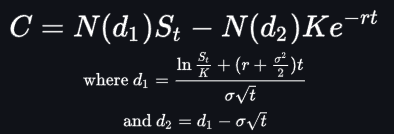

# Parameters Explained

<b>C</b> = Call Option Price, meaning how much it costs to buy the option.

<b>N (d<sub>1</sub>) and N (d<sub>2</sub>)</b> = Cumulative Normal Distribution Functions. These represent probabilities based on the normal distribution, used to estimate the likelihood of the option expiring in-the-money.

<b>S<sub>t</sub></b> = Current Stock Price, the price of the underlying asset (e.g., a stock) right now.

<b> K </b> = Strike price, the price at which you can buy the stock if you wish to exercise the option

<b> r </b> = Risk-free interest rate, the interest rate of a risk-free investment (e.g: government bond) over the option's life.

<b> t </b> = Time to expiration in years

<b> σ </b> = Volatility of the stock price. This is a measure of how much the stock price fluctuates over time. Higher volatility means the price moves more unpredictably.

# Intuition behind the equation

<b>N (d<sub>1</sub>) </b> measures how far the current stock price is from the strike price, adjusted for risk and time

<b>N (d<sub>2</sub>) </b> similar to <b>N (d<sub>1</sub>) </b> but accounts for volatility over time, representing the probability that the option will be exercised

The first term <b>N(d<sub>1</sub>)S<sub>t</sub></b> represents the expected value of owning the stock in the future.

The second term <b>N (d<sub>2</sub>)Ke<sup>-rt</sup></b> represents the present value of the cost you’d pay if you exercised the option.

# Nelson-Siegel Formula

Part of the black scholes equation is the risk free interest rate. The value for this can be estimated through the use of the Nelson-Siegel formula which is widely used in practice for fitting the term structure of interest rates

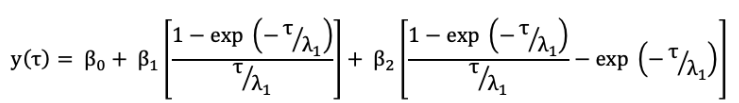

<b>B<sub>0</sub></b> = the long run levels of interest rates 

<b>B<sub>1</sub></b> = the short-term component

<b>B<sub>2</sub></b> = the medium-term component

<b> λ </b>= the decay factor

<b>tau</b> = maturity

<b> y(t) </b> = Yield of the curve at maturity t

The Nelson-Siegel model is a parametric model meaning we have to 'learn' parameters <b>B<sub>0</sub></b>, <b>B<sub>1</sub></b>, <b>B<sub>2</sub></b> and λ. This is done by minimising the difference between the actual treasury yields from the market and the Nelson-Siegel models predicted yields for the same maturities (tau).

# Types of Volatility

<b> Implied Volatility (IV) </b>
- The market's expectation of future volatility, derived from option prices.
- Found by reversing the Black-Scholes formula.
- More accurate for pricing, but requires option chain data.

<b> Historical Volatility (HV) </b>
- Measures how much the stock price has fluctuated in the past.
- Calculated using the standard deviation of log returns over a time period.
- Used when implied volatility is unavailable.

# Pricing European style Apple Options using Black-Scholes Formula

In [2]:
import yfinance as yf
from alpha_vantage.timeseries import TimeSeries
import numpy as np
import scipy.optimize as opt
from scipy.stats import norm


In [23]:
C_actual = float(input("Call Option Price ($)")) # To be compared against
K = float(input("Strike Price ($)")) #These need to be floats
maturity = float(input("Expiration of Option (years)")) #Currently can only take years (find way to also do months)

In [24]:
AAPL = yf.Ticker("AAPL")
St = AAPL.info['currentPrice']

### Calculating the risk-free interest rate using Nelson-Siegel

In [25]:
r_temp_1 = yf.Ticker("^IRX") #13 week treasury bill
r_temp_2 = yf.Ticker("^FVX") # Treasury Yield 5 years
r_temp_3 = yf.Ticker("^TNX") # CBOE Interest Rate 10 Year
r_temp_4 = yf.Ticker("2YY=F") #2-year yield futures

#Yields
Yield_1 = r_temp_1.info['previousClose']
Yield_2 = r_temp_2.info['previousClose']
Yield_3 = r_temp_3.info['previousClose']
Yield_4 = r_temp_4.info['previousClose']

Yields = np.array([Yield_1, Yield_2, Yield_3, Yield_4])
Maturities = np.array([0.25, 5, 10, 30]) #Time is measured in years 


def Nelson_Siegel_fn(b0,b1,b2,lambd,t):
    term_1 = b1 * (1-np.exp(-t/lambd) / (t/lambd))
    term_2 = b2 * (1-np.exp(-t/lambd) / (t/lambd)) - np.exp(-t/lambd)
    return b0 + term_1 + term_2

def obj_fcn(params,t,Yields):
    b0,b1,b2,lambd = params
    fitted_yields = Nelson_Siegel_fn(b0,b1,b2,lambd,t)
    return np.sum((fitted_yields - Yields) ** 2)

initial_guess = [1,2,3,4]
opt_parameters = opt.minimize(obj_fcn, initial_guess, args=(Maturities,Yields)).x #Finding Nelson Siegel parameters for corresponding risk-free assets

R = Nelson_Siegel_fn(*opt_parameters, maturity) / 100
print(R)

0.0437465360482123


### Calculating Historial Volatility

In [32]:
maturity_rounded = round(maturity)

historical_prices = AAPL.history(period=f'{maturity_rounded}y') #Cardinal rule of financial analysis: Use a historical period the same length as your time horizon.

log_returns = np.log(historical_prices['Close'] / historical_prices['Close'].shift(1)) # Compute daily log returns

daily_volatility = np.std(log_returns, ddof=1)  # Compute standard deviation of log returns, ddof=1 for sample standard deviation

annualized_volatility = daily_volatility * np.sqrt(252) # Annualize volatility (assuming 252 trading days per year)

print(annualized_volatility)

0.23832304851797342


### Calculating d1 & d2

In [33]:
d1 = (np.log(St / K) + (R + ((annualized_volatility**2) /2) ) * maturity) / (annualized_volatility*(np.sqrt(maturity)))
d2 = d1 - (annualized_volatility*np.sqrt(maturity))

N_d1 = norm.cdf(d1)
N_d2 = norm.cdf(d2)

print(maturity)
print(d1)
print(d2)

print(N_d1)
print(N_d2)#Check if this is correct

1
2.104756135812474
1.8664330872945003
0.9823437293871932
0.9690096012273532


### Calculating Call Option Price and Comparing

In [36]:
C_calculated = round((N_d1 * St) - (N_d2 * K * np.exp(-R*maturity)),2)

if C_calculated > C_actual:
    print("Buy!!")
if C_calculated < C_actual :
    print("Do not buy")

print("Calculated Price of Option is: $", C_calculated, "And the listed price is: $", C_actual)

Buy!!
Calculated Price of Option is: $ 93.08 And the listed price is: $ 91.74


# Pricing American style Apple Options

As eluded earlier, the PDE and SDE approaches are effective for pricing american style options due to the nature of american style options being able to be exercised at any date up to the expiration. In this script we are going to explore both options. Firstly, the PDE expression:

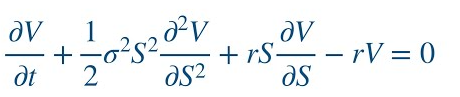

<b> V(S,t) </b>= Option Price as a function fo stock price S and time t.

<b> σ </b> = Volatility of the underlying asset

<b> r </b> = risk-free interest rate

<b> S </b> = Spot price of the underlying asset

<b> t </b> = time to maturity

### Breaking It Down Term by Term

**$\frac{\partial V}{\partial t}$ → Time Decay (*Theta*)**  
   - Measures how the option’s price changes as time passes.  
   - For most options, value decreases as expiration nears (*time decay effect*).

**$\frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2}$ → Gamma Effect (*Convexity*)**  
   - Reflects how the rate of change of the option’s delta varies with the stock price.  
   - The higher the volatility ($\sigma$), the more this term impacts the option price.  
   - Captures the effect of randomness in the asset price movement.

**$rS \frac{\partial V}{\partial S}$ → Delta & Carrying Cost**  
   - Tied to how the option price moves with the underlying stock (*Delta*).  
   - Also includes the effect of financing or carrying costs due to the risk-free rate.

**$-rV$ → Discounting to Present Value**  
   - Accounts for the time value of money, discounting the expected future payoff at the risk-free rate.




### Calculating Time Decay (Theta) Term

Monte Carlo simulation is useful when the Black-Scholes assumptions don’t hold, particularly in these cases:

- American options (Monte Carlo can estimate expected values along multiple paths).
- Path-dependent options (Asian, Barrier, Lookback options).
- Uncertain or stochastic volatility (e.g., if you want volatility to change dynamically).
- Dividend-paying stocks with complex dividend schedules.

How Monte Carlo Works for Option Pricing:
- Simulate many possible stock price paths over time using a stochastic process like Geometric Brownian Motion (GBM).
- Calculate the option payoff at expiration for each simulated path.
- Discount the payoffs back to the present to get the option price.
- Take the average across all simulations.